# Triangulacja Delaunaya

In [1]:
!python -m pip install kdtree
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js
import random
import time

TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
         
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
    
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


In [2]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
     
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

In [3]:
SCENES=[]
VISUALISATION=False

In [4]:
import math
import numpy as np
from scipy.spatial import distance
EPS= 8

class Graph() :
    def __init__(self):
        self.map = dict()
        self.lines_map = dict()

    def add_triangle(self, triangle):
        self.map[triangle] = []
        if triangle.line_a in self.lines_map:
            t = self.lines_map[triangle.line_a]
        else:
            self.lines_map[triangle.line_a] = []
            t = []
        for tri in t:
            self.map[triangle].append(tri)
            self.map[tri].append(triangle)

        self.lines_map[triangle.line_a].append(triangle)

        if triangle.line_b in self.lines_map:
            t = self.lines_map[triangle.line_b]
        else:
            self.lines_map[triangle.line_b] = []
            t = []
        for tri in t:
            self.map[triangle].append(tri)
            self.map[tri].append(triangle)
            
        self.lines_map[triangle.line_b].append(triangle)

        if triangle.line_c in self.lines_map:
            t = self.lines_map[triangle.line_c]
        else:
            self.lines_map[triangle.line_c] = []
            t = []
        for tri in t:
            self.map[triangle].append(tri)
            self.map[tri].append(triangle)
            
        self.lines_map[triangle.line_c].append(triangle)

    def remove_triangle(self, triangle):
        if(triangle in self.map):
            self.lines_map[triangle.line_a].remove(triangle)
            self.lines_map[triangle.line_b].remove(triangle)
            self.lines_map[triangle.line_c].remove(triangle)

            for t in self.get_neighbours(triangle):
                self.map[t].remove(triangle)
            
            del self.map[triangle]

    def get_neighbours(self, triangle):
        if(triangle not in self.map):
             return []
        return self.map[triangle]

    def to_list(self):
        return self.map.keys()

class TriangleIterator:
    def __init__(self, triangle_graph, triangle, point):
        self.triangle_graph = triangle_graph
        self._triangle = triangle
        self.queue = [triangle]
        self.visited = {triangle}
        self.point = point

    def __next__(self):
        if len(self.queue) > 0:
            triangle_to_ret = self.queue.pop(0)
            neighbours = self.triangle_graph.get_neighbours(triangle_to_ret)
    
            bad_neighbours = list(filter(lambda tri: tri not in self.visited \
                                         and tri.in_circumcil(self.point),neighbours))
            for tri in bad_neighbours:
                self.visited.add(tri)
            self.queue = self.queue + bad_neighbours
            return triangle_to_ret
        else:
            raise StopIteration


class TrianglesSet:
    def __init__(self):
        self.graph = Graph()
        self.neigh_list = []
        self.triangle = None
        self.point = None
        
    def __iter__(self):
        return TriangleIterator(self.graph, self.triangle, self.point)

    def update(self, point):
        for tri in self.neigh_list:
            if VISUALISATION:
                points = SCENES[0].points[0]
                lines = SCENES[0].lines[0]
                bad_lines = tri.as_raw()
                SCENES.append(Scene(points=[points,PointsCollection([point.as_tuple()], color='red')],\
                                lines=[lines,LinesCollection(bad_lines, color='purple')]))
            if(tri.in_circumcil(point)):
                self.triangle = tri
                break
        
        self.point = point

    def add(self, triangle):
        self.neigh_list.append(triangle)
        self.graph.add_triangle(triangle)
    
    def add_triangles(self, triangles = []):
        for tri in triangles:
            self.add(tri)
    
    def remove(self, triangle):
        self.neigh_list.remove(triangle)
        self.graph.remove_triangle(triangle)
        
    def to_list(self):
        return self.graph.to_list()

def circle_on_three_points(p1,p2,p3):
    A = np.array([
        0,                                0,   0,  1, 
        math.pow(p1.x,2)+math.pow(p1.y,2),p1.x,p1.y,1, 
        math.pow(p2.x,2)+math.pow(p2.y,2),p2.x,p2.y,1,
        math.pow(p3.x,2)+math.pow(p3.y,2),p3.x,p3.y,1
    ]).reshape((4,4))

    M11 = np.delete(np.delete(A,obj=0, axis=0), obj=0, axis = 1)
    det11 = np.linalg.det(M11)
    if det11 == 0:
        return False, (0,0),(0,0),0
    else:
        M12 = np.delete(np.delete(A,obj=0, axis=0), obj=1, axis = 1)
        M13 = np.delete(np.delete(A,obj=0, axis=0), obj=2, axis = 1)
        M14 = np.delete(np.delete(A,obj=0, axis=0), obj=3, axis = 1)

        x0 = (np.linalg.det(M12))/(2*det11)
        y0 = -(np.linalg.det(M13))/(2*det11)
        r = math.sqrt(math.pow(x0, 2)+math.pow(y0, 2)+np.linalg.det(M14)/det11)

        return True, x0, y0, r

def d(p1, p2):
    return distance.euclidean((p1.x, p1.y),(p2.x, p2.y))

class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def round_cords(self, r=4):
        self.x = round(self.x, r)
        self.y = round(self.y, r)

    def as_tuple(self):
        return (self.x, self.y)
    
    def __str__(self):
        return str(self.as_tuple())
    
    def __hash__(self):
        return hash((self.x, self.y))
    
class Line:
    def __init__(self, a=0,b=0, raw_line = None):
        if raw_line is None:
            self.point_a = min([a,b], key=lambda point: point.as_tuple()) 
            self.point_b = max([a,b], key=lambda point: point.as_tuple()) 
        else:
            self.point_a = Point(raw_line[0][0], raw_line[0][1])
            self.point_b = Point(raw_line[1][0], raw_line[1][1])

    def round_cords(self, r=4):
        self.point_a.round_cords(r)
        self.point_b.round_cords(r)

    def __hash__(self):
        return hash(self.as_raw())
    
    def __str__(self):
        return str([self.point_a.as_tuple(), self.point_b.as_tuple()])
    def __eq__(self, value):
        return self.as_raw() == value.as_raw()

    def as_raw(self):
        return (self.point_a.as_tuple(), self.point_b.as_tuple())

class Circle:
    def __init__(self, r, c):
        self.radius = r
        self.center = c

class Triangle:
    def __init__(self, a, b, c):
        valid, x0, y0, r = circle_on_three_points(a,b,c)
        if not valid:
            raise Exception("Points are collinear")
        self.circle = Circle(r, Point(x0, y0))
        self.point_a = a 
        self.point_b = b 
        self.point_c = c
        self.line_a = Line(a,b)
        self.line_b = Line(b,c)
        self.line_c = Line(c,a)
        self.circle = Circle(r, Point(x0, y0))


    def in_circumcil(self, point):
        if(d(point, self.circle.center) >= self.circle.radius):
            return False
        else:
            return True
    
    def as_raw(self):
        return [self.line_a.as_raw(), self.line_b.as_raw(), self.line_c.as_raw()]

    def __hash__(self):
        return hash((self.point_a.as_tuple(), self.point_b.as_tuple(), self.point_c.as_tuple()))
    
    def __eq__(self, value):
        return self.circle.center.as_tuple() == value.circle.center.as_tuple() 

def delunay(points):

    triangulation = TrianglesSet()

    points = [Point(point[0], point[1]) for point in points]
    
    for point in points:
        point.round_cords(5)
        
    max_x = max(points, key=lambda point: point.x).x
    min_x = min(points, key=lambda point: point.x).x
    max_y = max(points, key=lambda point: point.y).y
    min_y = min(points, key=lambda point: point.y).y

    v_point_1 = Point(min_x-1, min_y-1)
    v_point_2 = Point(max_x+1, min_y-1)
    v_point_3 = Point(max_x+1, max_y+1)
    v_point_4 = Point(min_x-1, max_y+1)

    bounding_verticies = {v_point_1.as_tuple(), v_point_2.as_tuple(), v_point_3.as_tuple(), v_point_4.as_tuple()}

    points = points + [v_point_1, v_point_2, v_point_3, v_point_4]

    super_tri_1 = Triangle(v_point_1, v_point_2, v_point_4)
    super_tri_2 = Triangle(v_point_2, v_point_3, v_point_4)

    triangulation.add(super_tri_1)
    triangulation.add(super_tri_2)

    for point in points:
        polygon = []
        bad_triangles = []
        triangulation.update(point)
        for tri in triangulation:
            if tri.in_circumcil(point): 
                bad_triangles.append(tri)
                if tri.line_a.as_raw() in polygon:
                    polygon.remove(tri.line_a.as_raw())
                else:
                    polygon.append(tri.line_a.as_raw())

                if tri.line_b.as_raw() in polygon:
                    polygon.remove(tri.line_b.as_raw())
                else:
                    polygon.append(tri.line_b.as_raw())

                if tri.line_c.as_raw() in polygon:
                    polygon.remove(tri.line_c.as_raw())
                else:
                    polygon.append(tri.line_c.as_raw())
        
        for tri in bad_triangles:
            triangulation.remove(tri)

        polygon = [Line(raw_line=line) for line in polygon]
        for line in list(polygon):
            try:
                t = Triangle(point, line.point_a, line.point_b)
            except:
                t = None
            
            if not(t is None):
                triangulation.add(t)

    result = []

    for tri in triangulation.to_list():
        if tri.point_a.as_tuple() in bounding_verticies or tri.point_b.as_tuple() in bounding_verticies\
        or tri.point_c.as_tuple() in bounding_verticies:
            pass
        else:
            result.append(tri)


    return result

def finding_bad_triangles_visualisation(triangulation, point):
    triangulation.update(point)
    bad_triangles = []    
    points = SCENES[0].points[0]
    linesCol = SCENES[0].lines[0]
    for tri in triangulation:
        if tri.in_circumcil(point):
            bad_triangles.append(tri)
            bad_lines = []
            for t in bad_triangles:
                bad_lines = bad_lines + t.as_raw()
                
            SCENES.append(Scene(points=[points,PointsCollection([point.as_tuple()], color='red')],\
                                lines=[linesCol,LinesCollection(bad_lines, color='red')]))


<IPython.core.display.Javascript object>


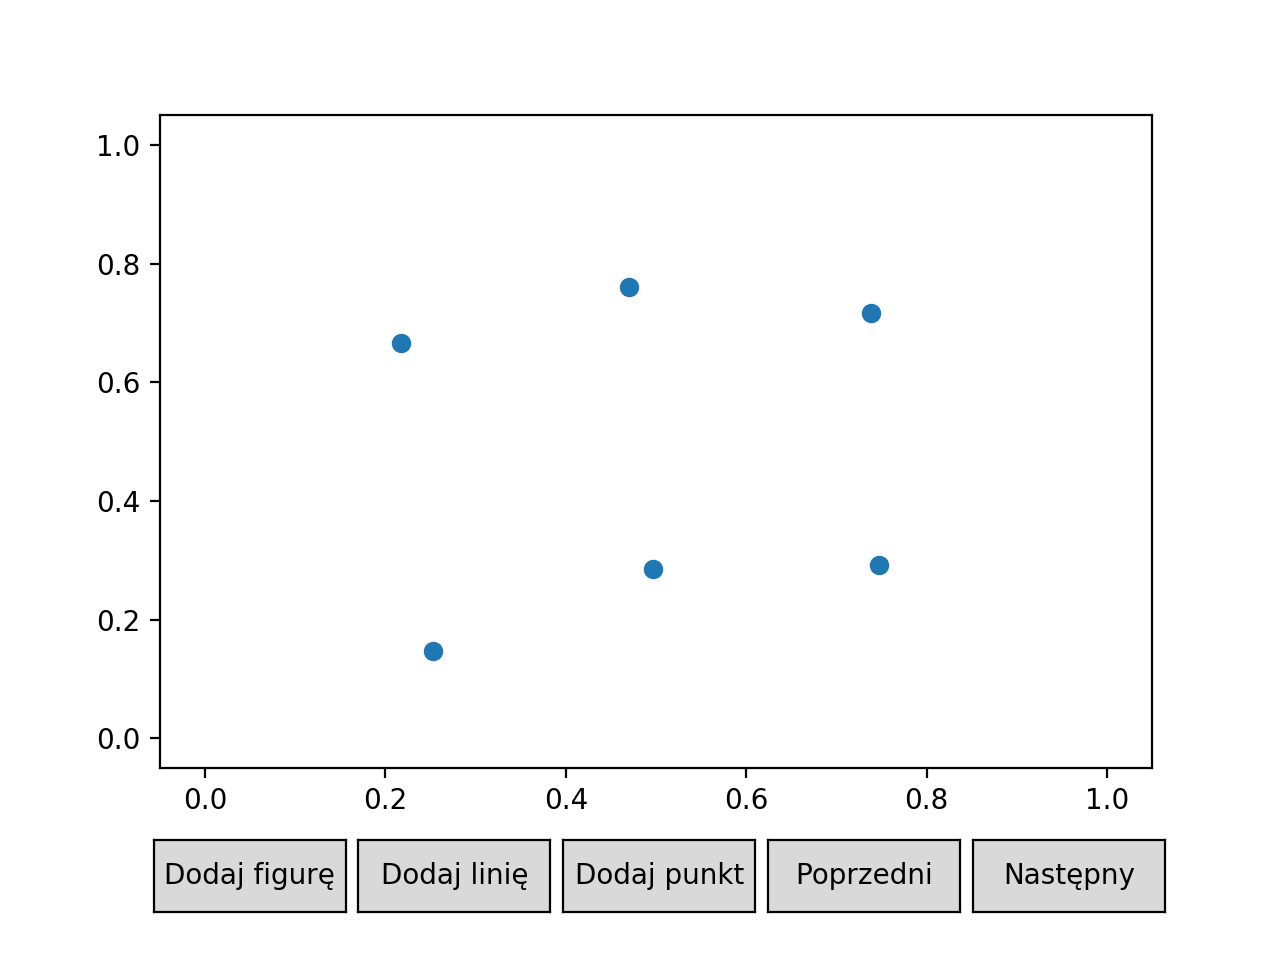

In [12]:
#Dodaj tu punkty, figury i/lub odcinki!
plot1 = Plot()
plot1.draw()

FastTime : 0.022616147994995117 sec



<IPython.core.display.Javascript object>


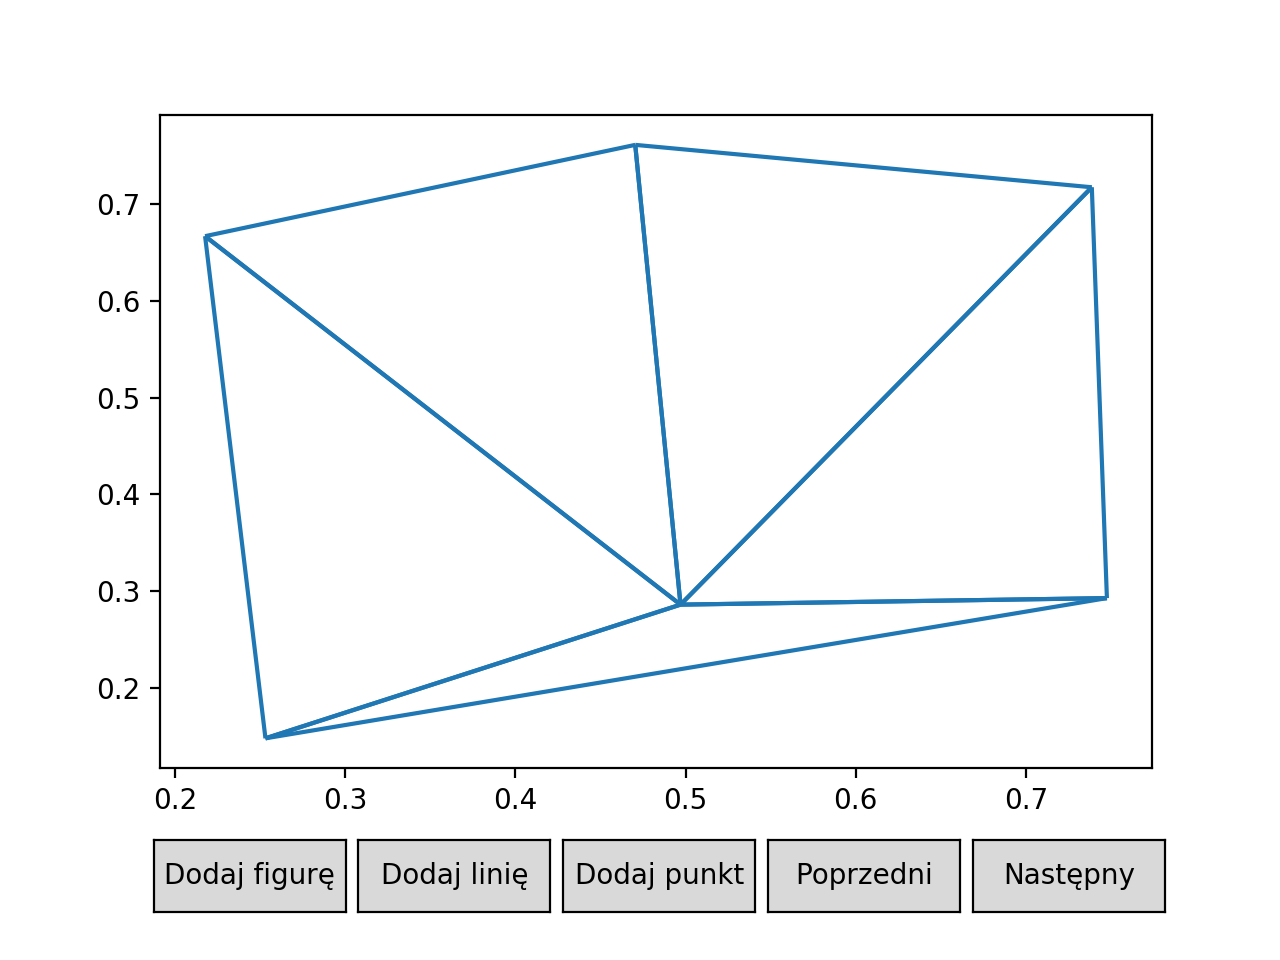

In [13]:
plot2 = Plot([])
points = plot1.get_added_elements().points[0].points
start_time = time.time()
tri = delunay(points)
print("FastTime : %s sec" % (time.time() - start_time))
lines = []
for t in tri:
    lines = lines + t.as_raw()

print()
plot2.scenes.append(Scene(lines=[LinesCollection(lines)]))
plot2.draw()

In [5]:
%matplotlib notebook

def get_random(range_min,range_max):
    return random.uniform(range_min,range_max)

def get_random_point(range_min,range_max):
    return Point(get_random(range_min,range_max), get_random(range_min,range_max))

def get_random_from_range(range_min,range_max,n):
    points = []
    for i in range(0,n):
        points.append((get_random(range_min,range_max), get_random(range_min,range_max)))
    return points 

FastTime : 10.09932017326355 sec



<IPython.core.display.Javascript object>


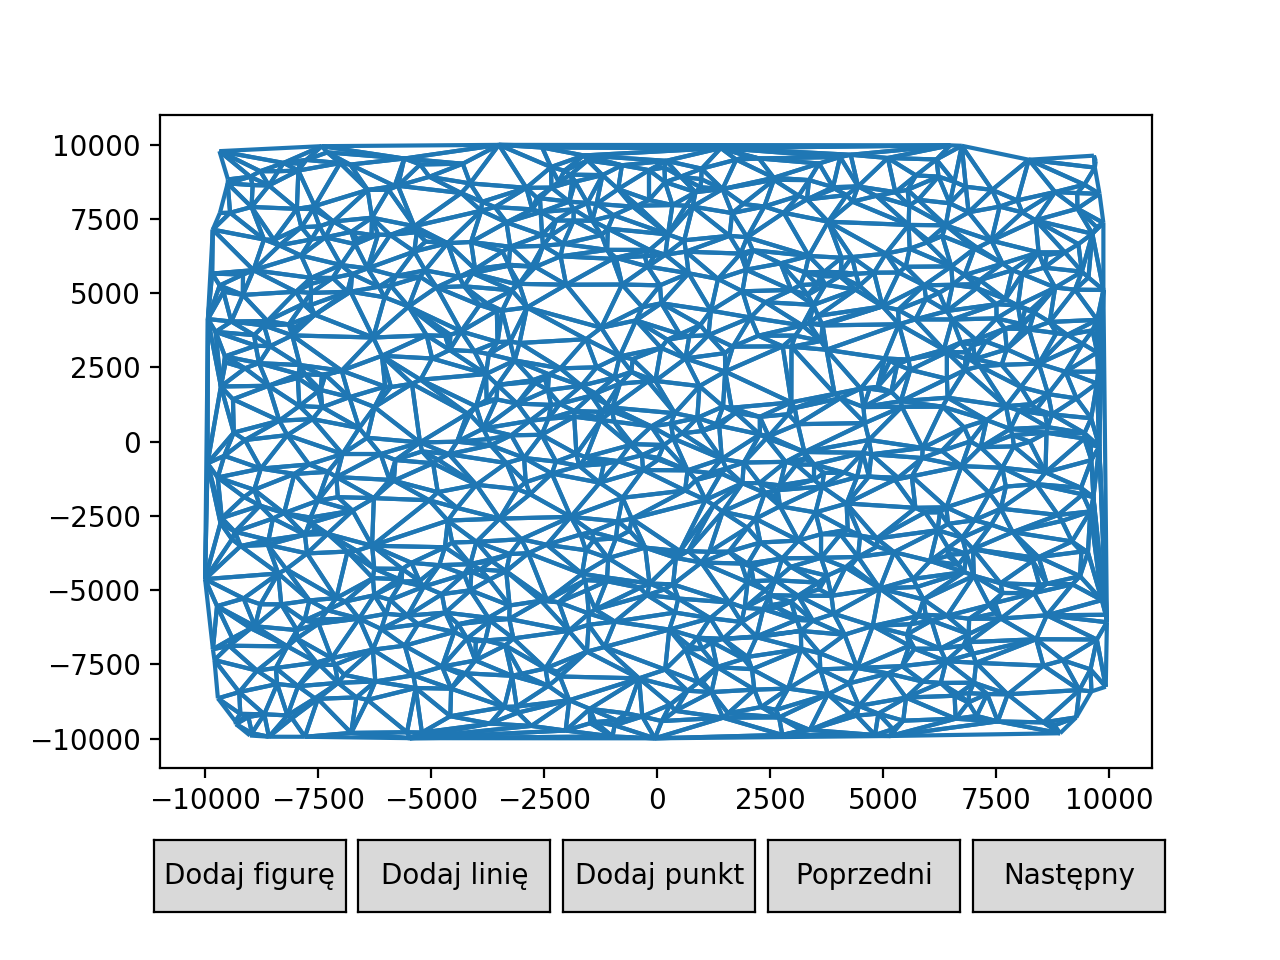

In [6]:
plot2 = Plot([])
points = get_random_from_range(-10000,10000,1000)
start_time = time.time()
tri = delunay(points)
print("FastTime : %s sec" % (time.time() - start_time))
lines = []
for t in tri:
    lines = lines + t.as_raw()

print()
plot2.scenes.append(Scene(lines=[LinesCollection(lines)]))
plot2.draw()

# Wizualizacja znajdowania trójkąta do którego wpada punkt

<IPython.core.display.Javascript object>


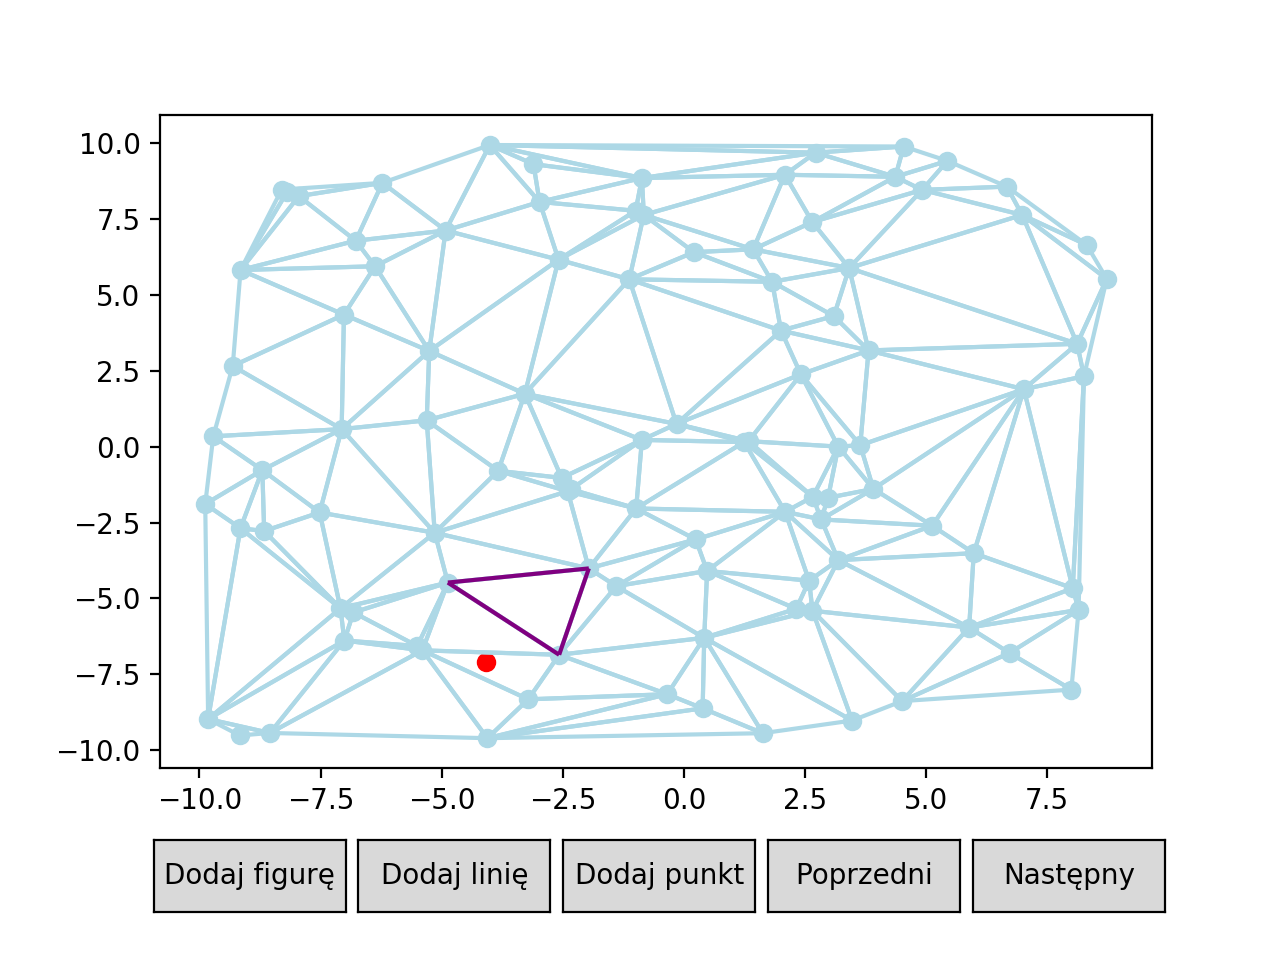

In [14]:
points1 = get_random_from_range(-10,10,100)
tri = delunay(points1)
l = []
for t in tri:
    l = l + t.as_raw()

VISUALISATION =True
SCENES = []    
SCENES.append(Scene(points=[PointsCollection(points1, color='lightblue')],lines=[LinesCollection(l, color='lightblue')]))

triangulation = TrianglesSet()
triangulation.add_triangles(tri)

finding_bad_triangles_visualisation(triangulation, get_random_point(-9,9))

plot2 = Plot(SCENES)
plot2.draw()

SCENES = []
VISUALISATION = False